<a href="https://colab.research.google.com/github/SergeySkopin/SergeyS_pet/blob/master/Guided_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.autograd import Variable
from skimage.io import imread
from PIL import Image
from skimage.transform import resize

**Preprocessing**

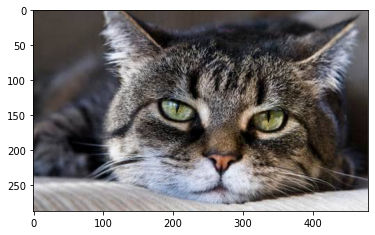

In [ ]:
#Загружаем свое изображение
image = Image.open("cat.jpg")
imshow(image)

In [ ]:
norm_data = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   norm_data
])
display = transforms.Compose([transforms.Resize((224,224))])
tensor = preprocess(image)
pred = Variable((tensor.unsqueeze(0)), requires_grad=True)

**Define model for guided bp and grad-cam**

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
features_fn = nn.Sequential(*list(model.children())[:-2])
classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))    
model = model.eval()

def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img)
    _, N, H, W = feats.size()
    c_score = classifier_fn(feats)[0,c]
    grads = torch.autograd.grad(c_score, feats) #Computes and returns the sum of gradients of outputs with respect to the inputs. 
    w = grads[0][0].mean(-1).mean(-1)
    gradcam = torch.matmul(w, feats.view(N, H*W))
    gradcam = gradcam.view(H, W).cpu().detach().numpy()
    gradcam = np.maximum(gradcam, 0)
    return gradcam

def prep_output(img_tensor):
    out = norm_data(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)

    return out

def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_hook_function)

def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]

    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


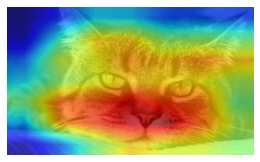

In [ ]:
prob, class_cl = torch.topk(nn.Softmax(dim=1)(model(pred)), 3)
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
gradcam = GradCAM(pred, int(class_cl[0][0]), features_fn, classifier_fn)
gradcam_test = resize(gradcam,(224,224), preserve_range=True)
gradcam_image = Image.fromarray(gradcam)
gradcam_image = gradcam_image.resize(image.size, resample=Image.LINEAR)

#Plot grad_cam
plt.imshow(image)
plt.imshow(np.array(gradcam_image), alpha=0.7, cmap='jet')
plt.axis('off')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


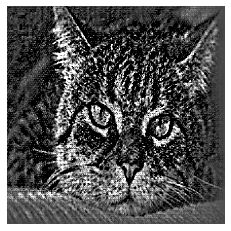

In [ ]:
#Plot guided backpropagation
out = model(pred)
loss = nn.CrossEntropyLoss()
input, target = out,torch.from_numpy(np.array([999]))
output_loss = loss(input,target).backward()
grads = pred.grad
plt.axis('off')
plt.imshow(norm_flat_image(grads),vmin=0.4, vmax=0.6, cmap="gray")

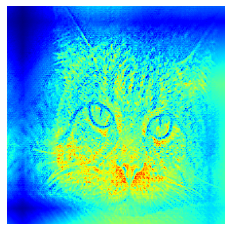

In [ ]:
#Plot Guided grad-cam
cam_gb = guided_grad_cam(gradcam_test, norm_flat_image(grads))
gradcam = Image.fromarray(cam_gb)
gradcam = gradcam.resize(image.size, resample=Image.LINEAR)
plt.axis('off')
plt.imshow(cam_gb, cmap='jet')
plt.show()